In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [3]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
import h5py as h5
import pandas as pd
from glob import glob

In [4]:
from src.wassersteinflowmatching.riemannian_wasserstein import RiemannianWassersteinFlowMatching

### Download single domain from mdCATH

In [5]:
from huggingface_hub import HfApi
from huggingface_hub import hf_hub_download

api = HfApi()
data_root = '.'

domain_id = '1r9lA02'
hf_hub_download(repo_id="compsciencelab/mdCATH", 
                filename=f"mdcath_dataset_{domain_id}.h5",
                subfolder='data',
                local_dir=data_root,
                repo_type="dataset")

'data/mdcath_dataset_1r9lA02.h5'

In [ ]:
import torch
from transformers import AutoModel, AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")
model = AutoModel.from_pretrained("facebook/esm2_t6_8M_UR50D")  
model = model.eval().cuda()

def get_sequence_embedding(sequence):
    # get ESM2 per-residue sequence embedding
    inputs = tokenizer(sequence, return_tensors="pt", add_special_tokens=True).to('cuda')
    with torch.no_grad():
        outputs = model(**inputs, return_dict=True)
    token_embeddings = outputs.last_hidden_state  # (1, seq_len, hidden_dim)
    sequence_embedding = token_embeddings[0, 1:-1, :].cpu().numpy()  # remove BOS and EOS tokens

    # convert to jax format
    sequence_embedding = jnp.array(sequence_embedding)

    return sequence_embedding

### Create $SE(3)^N$ frames from MD trajectories

In [ ]:
from prot_utils import get_ca_trajectory, atom2frame
from anim_utils import animate_protein_trajectory
from lovely_numpy import lo
import os

pc_frame_data = []
pc_seq_embeddings = []
MDCATH_PATH = "./data/"

def normalize_to_unit_range(trajectory):
    """Scale trajectory to [0, 1] range."""
    min_val = trajectory.min()
    max_val = trajectory.max()
    return (trajectory - min_val) / (max_val - min_val)

for cath_domain_folder in os.listdir(MDCATH_PATH):
    fp = os.path.join(MDCATH_PATH, cath_domain_folder)
    if not fp.endswith('.h5'):
        continue # process only h5 trajectory files

    ca_traj, n_traj, c_traj, domain_name, sequence = get_ca_trajectory(fp) # T, N_atoms, 3
    ca_traj = normalize_to_unit_range(ca_traj)
    n_traj = normalize_to_unit_range(n_traj)
    c_traj = normalize_to_unit_range(c_traj)
    print (len(sequence), sequence)

    # pc_seq_embeddings.append(get_sequence_embedding(sequence)) # |D|

    traj_frames = atom2frame(n_traj, ca_traj, c_traj) # T, N_residues, 7
    traj_frames = traj_frames.reshape(traj_frames.shape[0], -1) # flatten to (T, N_residues * 7)
    pc_frame_data.append(traj_frames)

2165 2165
141 AAQGYLIDKKTADQYKITNIAQLKDPKIAKLFDTNGDGKADLTGCNPGWGCEGAINHQLAAYELTNTVTHNQGNYAAMMADTISRYKEGKPVFYYTWTPYWVSNELKPGKDVVWLQVPFSALPGDKNADTKLPNGANYGFP


In [15]:
print (pc_frame_data)
print (len(pc_frame_data))

[array([[ 0.43200016,  0.04668588, -0.15885304, ...,  0.63362575,
         0.53091204,  0.36772084],
       [ 0.4868784 , -0.155317  , -0.24123001, ...,  0.62734133,
         0.5280147 ,  0.35421342],
       [ 0.5093629 ,  0.14647843, -0.80266786, ...,  0.63060594,
         0.5673128 ,  0.3618445 ],
       ...,
       [ 0.05709447,  0.26830843, -0.790447  , ...,  0.6250969 ,
         0.74899   ,  0.1596817 ],
       [ 0.12275884, -0.15588011,  0.40849748, ...,  0.66672105,
         0.72801465,  0.18179964],
       [ 0.17076492,  0.40330932, -0.88164616, ...,  0.63958377,
         0.7119363 ,  0.18024892]], shape=(450, 987), dtype=float32)]
1


In [16]:
class rwfm_config:
    geom: str = 'se3'
    monge_map: str = 'entropic'
    wasserstein_eps: float = 0.0005
    wasserstein_lse: bool = True
    num_sinkhorn_iters: int = -1
    mini_batch_ot_mode: bool = True
    mini_batch_ot_solver: str = 'chamfer'
    mini_batch_ot_num_iter: int = -1
    minibatch_ot_eps: float = 0.0005
    minibatch_ot_lse: bool = True
    noise_type: str = 'ambient_gaussian'
    noise_geom: str = 'se3'
    scaling: str = 'None'
    factor: float = 1.0
    embedding_dim: int = 512
    num_layers: int = 6
    num_heads: int = 4
    dropout_rate: float = 0.1
    mlp_hidden_dim: int = 512
    cfg: bool = False
    p_cfg_null: float = 0.0
    w_cfg: float = 1.0
    normalized_condition: bool = False

FlowMatchingModel = RiemannianWassersteinFlowMatching(point_clouds=pc_frame_data, config=rwfm_config)

Initializing WassersteinFlowMatching
Using se3 geometry
Projecting point clouds to geometry (with cpu)...


100%|██████████| 1/1 [00:00<00:00, 10.22it/s]

Using se3 geometry for noise


Using ambient_gaussian noise for se3 geometry.
Noise parameters:
  mean: [ 3.94753665e-01 -1.19476207e-01  9.58336145e-02 -1.13014504e-01
  6.66530132e-01  7.12723315e-01  2.21704721e-01  3.61017853e-01
 -6.59082532e-02  8.82879794e-02 -8.10468346e-02  6.64953947e-01
  7.12037683e-01  2.23439351e-01  3.50886345e-01  5.26630841e-02
  3.02176923e-04 -4.19805795e-02  6.62006736e-01  7.12164164e-01
  2.23997161e-01  3.22864830e-01 -8.43037367e-02  1.48636416e-01
 -1.63256004e-01  6.59088373e-01  7.13947654e-01  2.24425793e-01
  4.08790827e-01  1.20511249e-01  2.31229246e-01 -2.20377892e-01
  6.56071246e-01  7.14164972e-01  2.23235846e-01  3.93928289e-01
 -5.45090139e-02  1.50608197e-01  1.36423344e-02  6.55372441e-01
  7.12895334e-01  2.20977068e-01  3.92070591e-01  1.40746400e-01
  2.00205982e-01 -2.52541035e-01  6.52534127e-01  7.13449121e-01
  2.20269650e-01  4.65511292e-01 -4.25383225e-02  1.29577667e-01
  2.40337253e-02  6.51388466e-01  7.12491095e-01  2.18405545e-01
  3.82525146e-01 

: 

#### Train SE(3)-RWFM

In [ ]:

# might need to adjust hparams for overfitting run
FlowMatchingModel.train(batch_size = 1,
                        shape_sample = 200, # sample 200 MD frames from the trajectory at a time
                        training_steps = 500000, 
                        decay_steps = 5000)

In [ ]:
loss_smooth = np.convolve(np.log(FlowMatchingModel.losses), np.ones(100)/100, mode='valid')
plt.plot(loss_smooth)
plt.show()

#### Sample

In [ ]:
key = jax.random.PRNGKey(0)

In [ ]:
subkey,key = jax.random.split(key)
generated_samples, sample_weights = FlowMatchingModel.generate_samples(num_samples=1, # single trajectory
                                                            timesteps=1000,
                                                            size=20, # number of MD timesteps
                                                            key=subkey)
generated_samples = generated_samples[-1] # get final sampling timestep


In [ ]:
from prot_utils import trajectory_to_coords, save_trajectory_pdb

n_samples, n_timesteps, _ = generated_samples.shape
print (generated_samples.shape) # (n_samples, 400, N_residues * 7)
trajectory = generated_samples.view(n_timesteps, -1, 7) # (n_timesteps, N_residues, 7)
trajectory = trajectory.at[..., 0].set(1.0)  # unit quaternion w=1
coords = trajectory_to_coords(trajectory)  # (400, 50, 3, 3)
save_trajectory_pdb(coords, "toy_trajectory.pdb")

Best to visualise trajectory on Protein Viewer on VSCode, PyMol, or Molstar

In [35]:
from prot_utils import get_ca_trajectory, atom2frame
from anim_utils import animate_protein_trajectory
from lovely_numpy import lo
import os

toy_data = []
MDCATH_PATH = "./data/"

def normalize_to_unit_range(trajectory):
    """Scale trajectory to [0, 1] range."""
    min_val = trajectory.min()
    max_val = trajectory.max()
    return (trajectory - min_val) / (max_val - min_val)

for cath_domain_folder in os.listdir(MDCATH_PATH):
    fp = os.path.join(MDCATH_PATH, cath_domain_folder)
    if not fp.endswith('.h5'):
        continue # process only h5 trajectory files

    ca_traj, n_traj, c_traj, domain_name = get_ca_trajectory(fp) # T, N_atoms, 3
    ca_traj = normalize_to_unit_range(ca_traj)
    n_traj = normalize_to_unit_range(n_traj)
    c_traj = normalize_to_unit_range(c_traj)

    print (ca_traj.shape, n_traj.shape, c_traj.shape, domain_name)

    toy_data.append((n_traj, ca_traj, c_traj, domain_name))    

(450, 141, 3) (450, 141, 3) (450, 141, 3) 1r9lA02


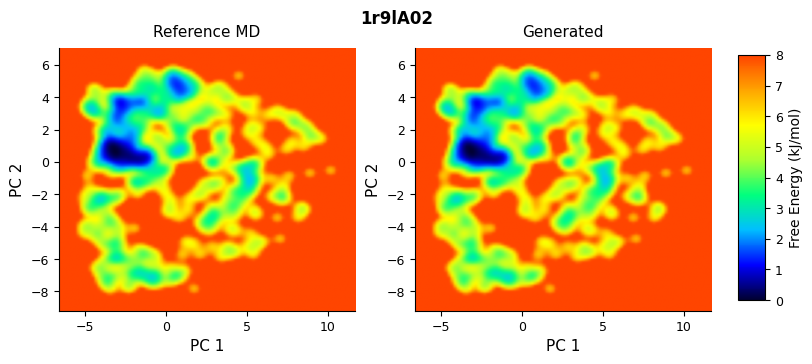

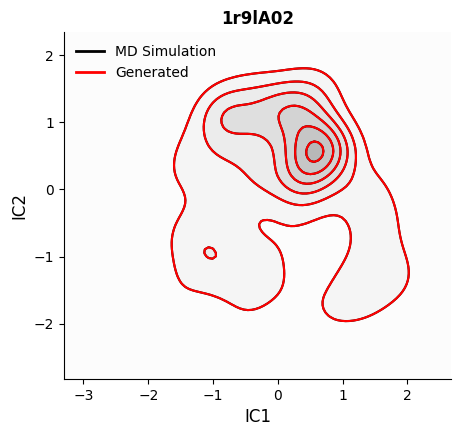

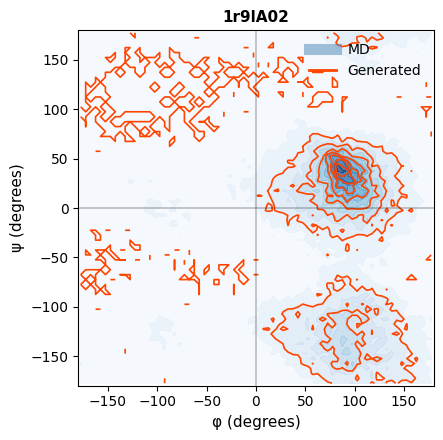

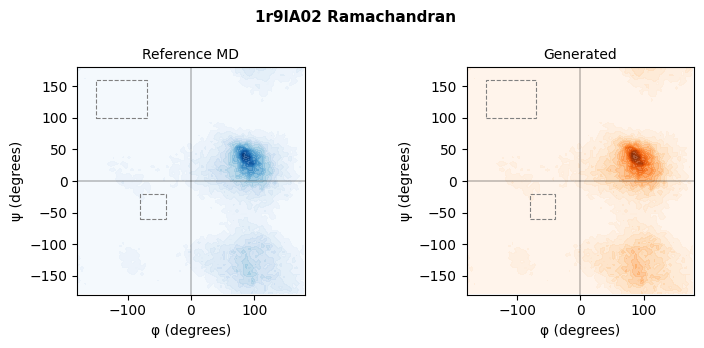

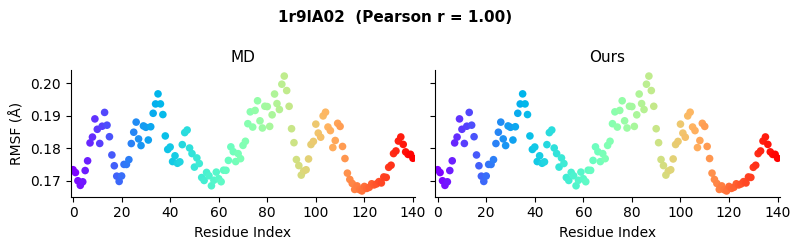

In [36]:
from prot_figure_utils import plot_ramachandran_overlay, plot_ramachandran_comparison, create_fes_plot, create_ica_contour_plot, plot_rmsf_comparison

np.random.seed(42)
# get N, CA, C coordinates from toy_data
toy_n_traj, toy_ca_traj, toy_c_traj, domain_name = toy_data[0]

fig, axes = create_fes_plot(
    toy_n_traj, toy_ca_traj, toy_c_traj,
    toy_n_traj, toy_ca_traj, toy_c_traj,
    protein_name=domain_name,
)

fix, axes = create_ica_contour_plot(
    toy_n_traj, toy_ca_traj, toy_c_traj,
    toy_n_traj, toy_ca_traj, toy_c_traj,
    protein_name=domain_name,    
)

# Ramachandran overlay
fig2, ax2 = plot_ramachandran_overlay(
    toy_n_traj, toy_ca_traj, toy_c_traj,
    toy_n_traj, toy_ca_traj, toy_c_traj,
    protein_name=domain_name
)

# Ramachandran side-by-side
fig3, axes3 = plot_ramachandran_comparison(
    toy_n_traj, toy_ca_traj, toy_c_traj,
    toy_n_traj, toy_ca_traj, toy_c_traj,
    protein_name=domain_name
)

fig, axes, r = plot_rmsf_comparison(
    toy_ca_traj,   # (n_frames, n_residues, 3)
    toy_ca_traj,   # (n_frames, n_residues, 3)
    protein_name=domain_name
)

plt.show()